## Stock Return Prediction

In this case study we will use various supervised learning-based models to predict the stock price of Microsoft using correlated assets and its own historical data.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)    
    * [4.2.Feature Selection](#3.2) 
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
        * [5.3.1 Machine Learning models-scikit-learn](#4.3.1)
        * [5.3.2 Time Series based Models-ARIMA and LSTM](#4.3.2)
* [6. Model Tuning and grid search](#5)
* [7. Finalise the model](#6)
    * [7.1. Result on the test dataset](#6.1)
    * [7.2. Save Model for Later Use](#6.2)     

<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, weekly return of the
Microsoft stock is the predicted variable. We need to understand what affects Microsoft stock price and hence incorporate as much information into the model. 

For this case study, other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [137]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import SGD
#from keras.layers import LSTM
#from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt


In [5]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

Next, we extract the data required for our analysis using pandas datareader. 

In [72]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

start = pd.to_datetime('1/1/2010')
end = pd.to_datetime('31/12/2019')

stk_data = web.DataReader(stk_tickers, 'yahoo', start, end)
ccy_data = web.DataReader(ccy_tickers, 'fred', start, end)
idx_data = web.DataReader(idx_tickers, 'fred', start, end)

Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.

In [75]:
return_period = 5

We now define our Y series and our X series

Y: MSFT **Future** Returns

X:

    a. GOOGL 5 Business Day Returns
    b. IBM 5 Business DayReturns    
    c. USD/JPY 5 Business DayReturns    
    d. GBP/USD 5 Business DayReturns    
    e. S&P 500 5 Business DayReturns    
    f. Dow Jones 5 Business DayReturns    
    g. MSFT 5 Business Day Returns    
    h. MSFT 15 Business Day Returns    
    i. MSFT 30 Business Day Returns    
    j. MSFT 60 Business Day Returns

We remove the MSFT past returns when we use the Time series models.

In [76]:
stk_data.head()

Attributes  Adj Close                             Close              \
Symbols          MSFT        IBM       GOOGL       MSFT         IBM   
Date                                                                  
2010-01-04  23.855658  84.331696  313.688690  30.950001  126.625237   
2010-01-05  23.863367  83.312973  312.307312  30.959999  125.095604   
2010-01-06  23.716919  82.771759  304.434448  30.770000  124.282982   
2010-01-07  23.470272  82.485252  297.347351  30.450001  123.852776   
2010-01-08  23.632135  83.312973  301.311310  30.660000  125.095604   

Attributes                   High                                Low  \
Symbols          GOOGL       MSFT         IBM       GOOGL       MSFT   
Date                                                                   
2010-01-04  313.688690  31.100000  127.122368  315.070068  30.590000   
2010-01-05  312.307312  31.100000  126.051628  314.234222  30.639999   
2010-01-06  304.434448  31.080000  125.707458  313.243256  30.520000   
2010-01-07  297.347351  30.700001  124.521988  305.305298  30.190001   
2010-01-08  301.311310  30.879999  125.162521  301.926941  30.240000   

Attributes                               Open                          \
Symbols            IBM       GOOGL       MSFT         IBM       GOOGL   
Date                                                                    
2010-01-04  125.095604  312.432434  30.620001  125.411087  313.788788   
2010-01-05  124.378586  311.081085  30.850000  125.889099  313.903900   
2010-01-06  124.101341  303.483490  30.879999  124.933075  313.243256   
2010-01-07  123.240921  296.621613  30.629999  124.158699  305.005005   
2010-01-08  123.374763  294.849854  30.280001  123.393883  296.296295   

Attributes      Volume                         
Symbols           MSFT        IBM       GOOGL  
Date                                           
2010-01-04  38409100.0  6438444.0   3908488.0  
2010-01-05  49749600.0  7156104.0   6003391.0  
2010-01-06  58182400.0  5863144.0   7949443.0  
2010-01-07  50559700.0  6109268.0  12815771.0  
2010-01-08  51197400.0  4390271.0   9439151.0

In [120]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name].asfreq('5B',method = 'pad')
X = dataset.loc[:, X.columns].asfreq('5B',method = 'pad')

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

Lets have a look at the dataset we have

In [106]:
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000
mean,0.004525,0.003893,-0.000373,0.000780,-0.000809,0.001803,0.001791,0.002344,0.004140,0.013044,0.027268,0.053367
std,0.030918,0.032934,0.027920,0.012136,0.012712,0.018417,0.018253,0.157677,0.031191,0.045760,0.061513,0.083777
min,-0.155315,-0.159181,-0.116332,-0.041651,-0.105527,-0.115810,-0.111328,-0.559093,-0.155315,-0.154438,-0.122458,-0.147896
25%,-0.012019,-0.013220,-0.013920,-0.005956,-0.007944,-0.004751,-0.006573,-0.085197,-0.010420,-0.009495,-0.009275,-0.004156
50%,0.005828,0.007142,0.000755,0.001023,-0.000762,0.003089,0.003285,-0.010495,0.005899,0.014221,0.028151,0.067210
75%,0.022977,0.022560,0.014846,0.007241,0.006735,0.012025,0.012141,0.079191,0.021557,0.040975,0.066419,0.111871
max,0.132076,0.174206,0.096916,0.058566,0.050990,0.056564,0.054636,0.960131,0.132076,0.169280,0.231473,0.262539


In [107]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2012-05-10,-0.027204,0.004311,-0.028384,-0.005616,-0.001484,-0.024427,-0.026980,0.069828,-0.032643,-0.008745,-0.046091,0.016068
2012-05-17,-0.022114,0.015186,-0.013601,-0.008167,-0.021136,-0.039910,-0.032619,0.262814,-0.027204,-0.070807,-0.042378,-0.044299
2012-05-24,-0.021559,-0.031616,-0.009138,0.002646,-0.007931,0.012051,0.006989,-0.128353,-0.022114,-0.081961,-0.057095,-0.081331
2012-06-01,0.041314,-0.055657,-0.036403,-0.018119,-0.017080,-0.030651,-0.027370,0.203091,-0.021559,-0.070876,-0.079622,-0.106035
2012-06-11,0.032009,-0.017593,0.020838,0.015209,0.008609,0.023773,0.025276,-0.103151,0.012185,-0.012722,-0.094729,-0.121570


<a id='2.2'></a>
## 3.2. Data Visualization

Next, lets look at the distribution of the data over the entire period

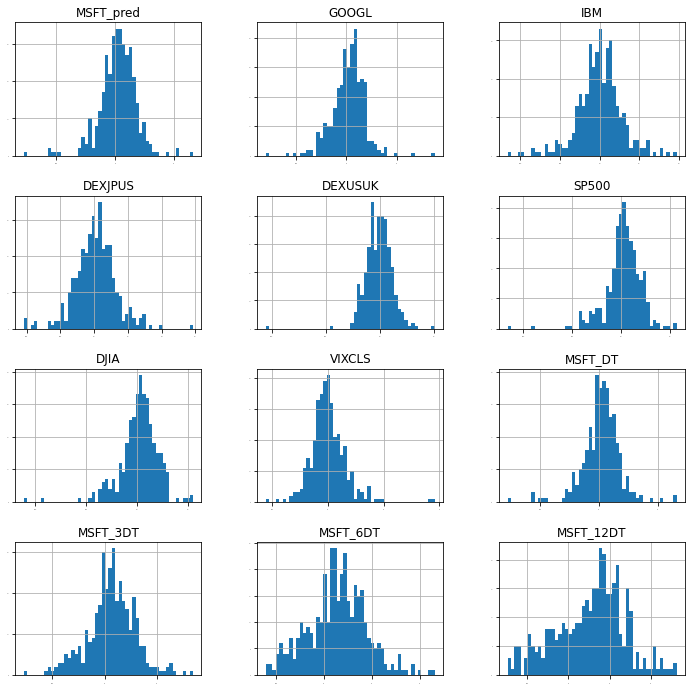

In [108]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

The above histogram shows the distribution for each series individually. Next, lets look at the density distribution over the same x axis scale.

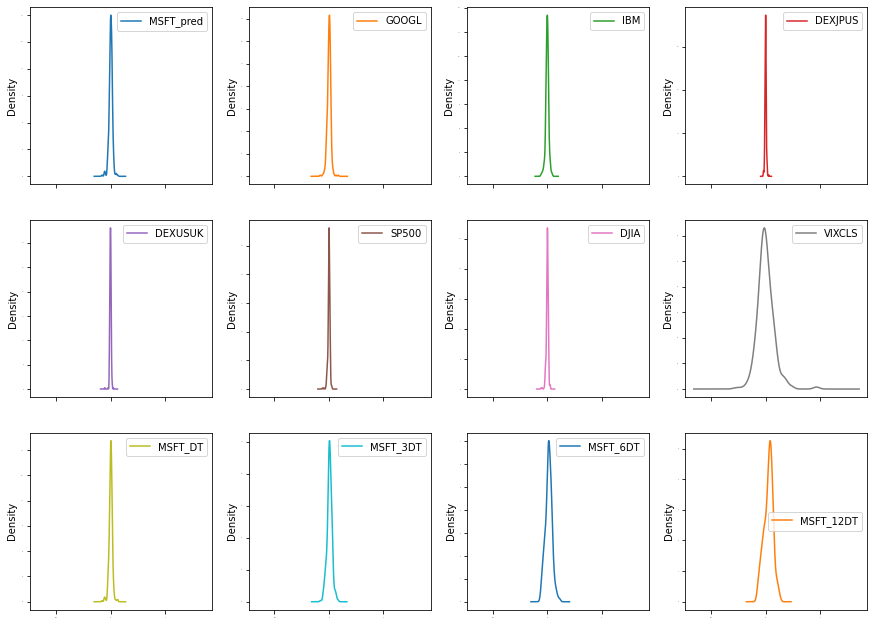

In [109]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

We can see that the vix has a much larger variance compared to the other distributions.

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

<AxesSubplot:title={'center':'Correlation Matrix'}>

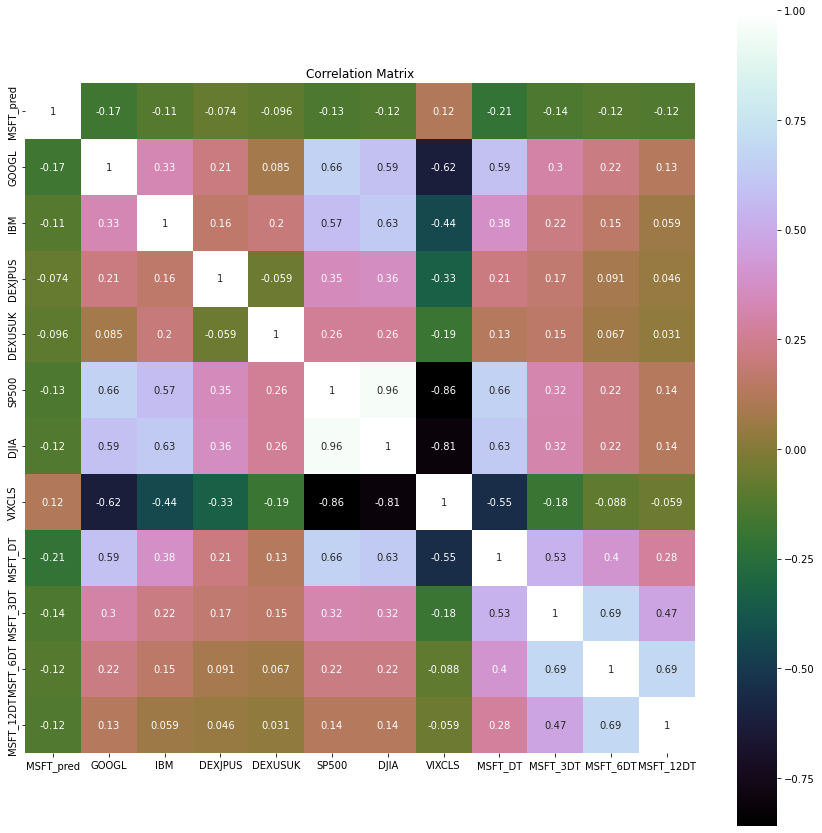

In [110]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Looking at the correlation plot above, What can we conclude?

<Figure size 1080x1080 with 0 Axes>

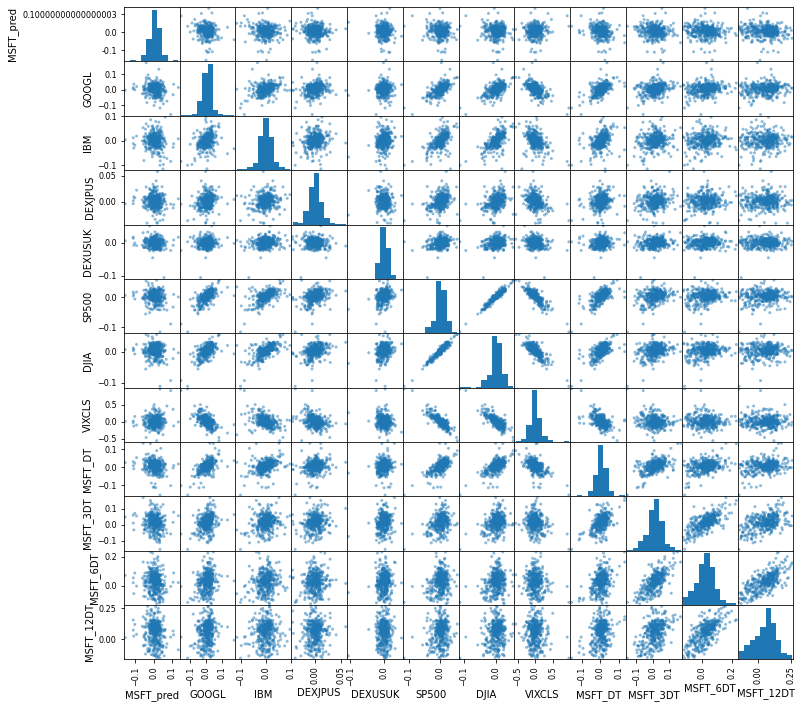

In [111]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

Looking at the scatter plot above, we see some linear relationship of the predicted variable with another variable?

<a id='2.3'></a>
## 3.3. Time Series Analysis 

Next, we look at the seasonal decomposition of our time series

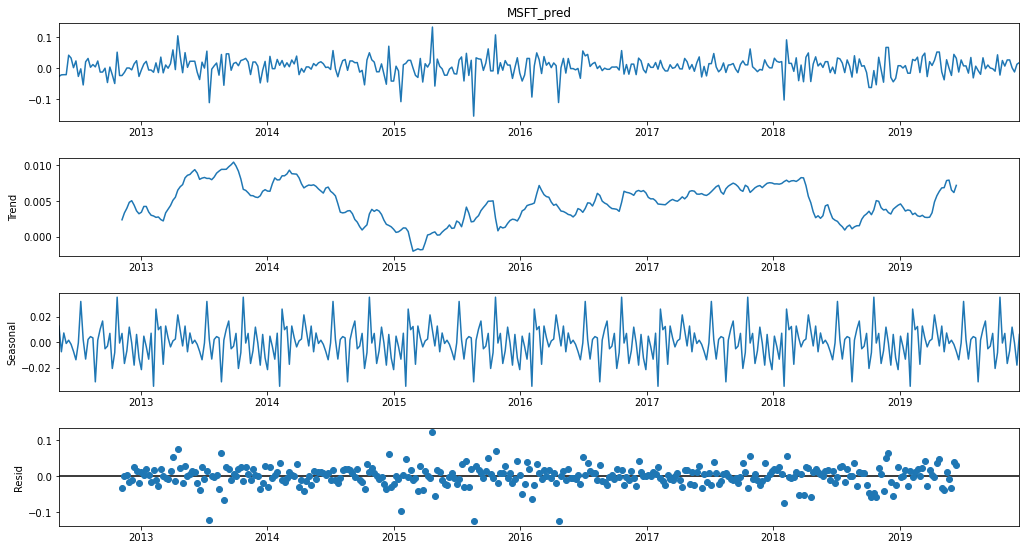

In [114]:
res = sm.tsa.seasonal_decompose(Y, model = "additive")
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

What can we conclude from this graph?

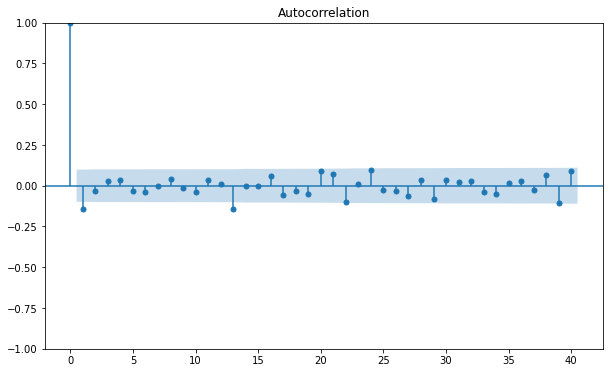

In [115]:
plt.rc("figure", figsize=(10,6))
plot_acf(Y, lags=40);
plt.show()

<a id='3'></a>
## 4. Data Preparation

<a id='3.2'></a>
## 4.2. Feature Selection

We use sklearn's SelectKBest function to get a sense of feature importance. 

In [122]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_DT,19.228731
GOOGL,10.231834
SP500,8.490808
MSFT_3DT,7.434569
DJIA,7.309453
IBM,6.732817
MSFT_12DT,6.045127
VIXCLS,5.791101
MSFT_6DT,4.876311


Which features are the most importants?

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

Next, we start by splitting our data in training and testing chunks. If we are going to use Time series models we have to split the data in continous series.

In [123]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics

In [124]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1 Machine Learning models-from scikit-learn

##### Regression and Tree Regression algorithms

In [125]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

##### Neural Network algorithms

In [126]:
models.append(('MLP', MLPRegressor()))

##### Ensable Models

In [127]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them. First we run the K-fold analysis. Next we run the model on the entire training and testing dataset.

In [129]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000960 (0.000496) 0.000881 0.000819
LASSO: 0.000957 (0.000525) 0.000957 0.000796
EN: 0.000957 (0.000525) 0.000957 0.000796
KNN: 0.001109 (0.000483) 0.000666 0.001003
CART: 0.002221 (0.000806) 0.000000 0.002288
SVR: 0.001920 (0.000575) 0.001867 0.001874
MLP: 0.001047 (0.000543) 0.001346 0.001048
ABR: 0.001121 (0.000530) 0.000557 0.001011
GBR: 0.001160 (0.000628) 0.000170 0.001179
RFR: 0.001080 (0.000595) 0.000135 0.000952
ETR: 0.001062 (0.000564) 0.000000 0.000991


#### K Fold results

We being by looking at the K Fold results

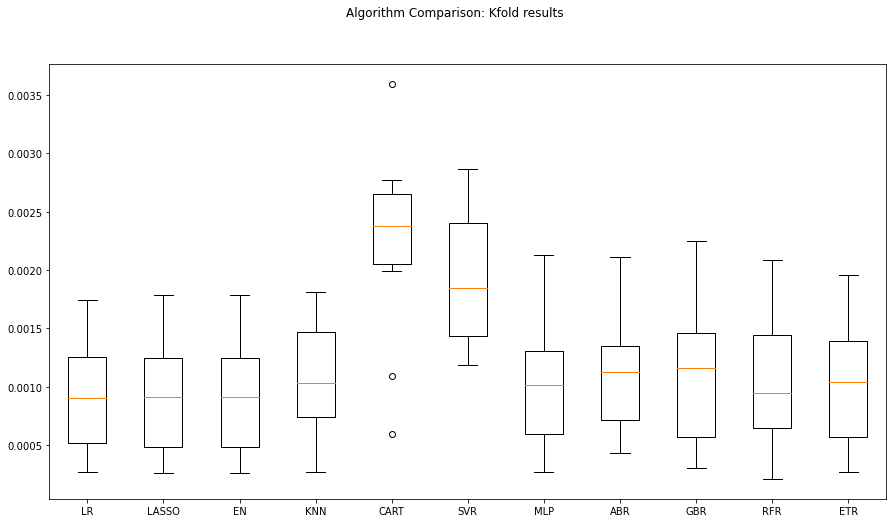

In [130]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

We see the linear regression and the regularized regression including the Lasso regression (LASSO) and elastic net (EN) seem to do a good job.

#### Training and Test error

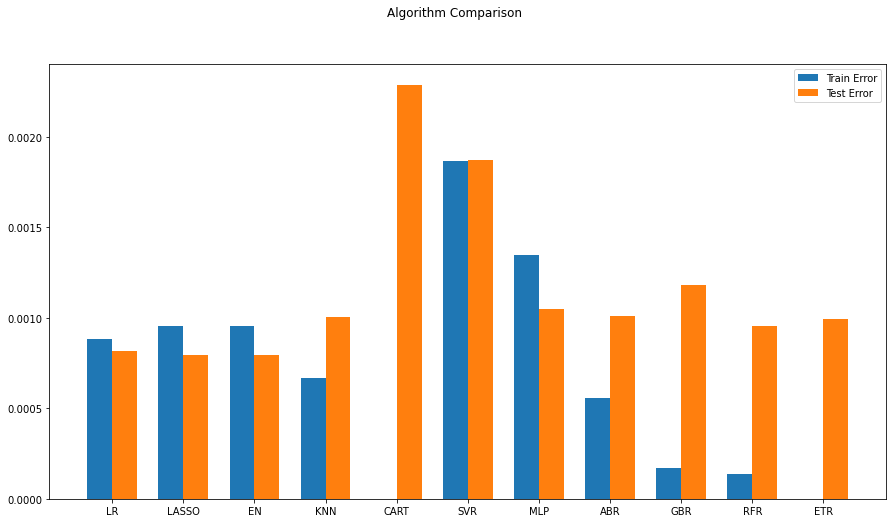

In [131]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Looking at the training and test error, we still see a better performance of the linear models. Some of the algorithms, such as the decision tree regressor (CART) overfit on the training data and produced very high error on the test set and these models should be avoided. Ensemble models, such as gradient boosting regression (GBR) and random forest regression (RFR) have low bias but high variance (overfitting). We also see that the artificial neural network (shown as MLP is the chart) algorithm shows higher errors both in training set and test set, which is perhaps due to the linear relationship of the variables not captured accurately by ANN or improper hyperparameters or insufficient training of the model.

<a id='4.3.1'></a>
### 5.3.1 Time Series based models-ARIMA

Let us first prepare the dataset for ARIMA models, by having only the correlated varriables as exogenous variables.

### Time Series Model - ARIMA Model

In [134]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [138]:
modelARIMA=ARIMA(endog = Y_train, exog = X_train_ARIMA, order=(1,0,0))
model_fit = modelARIMA.fit()

In [139]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0008247895194233503

#### Append to previous results

In [140]:
test_results.append(error_Test_ARIMA)
train_results.append(error_Training_ARIMA)
names.append("ARIMA")

## Overall Comparison of all the algorithms ( including Time Series Algorithms)

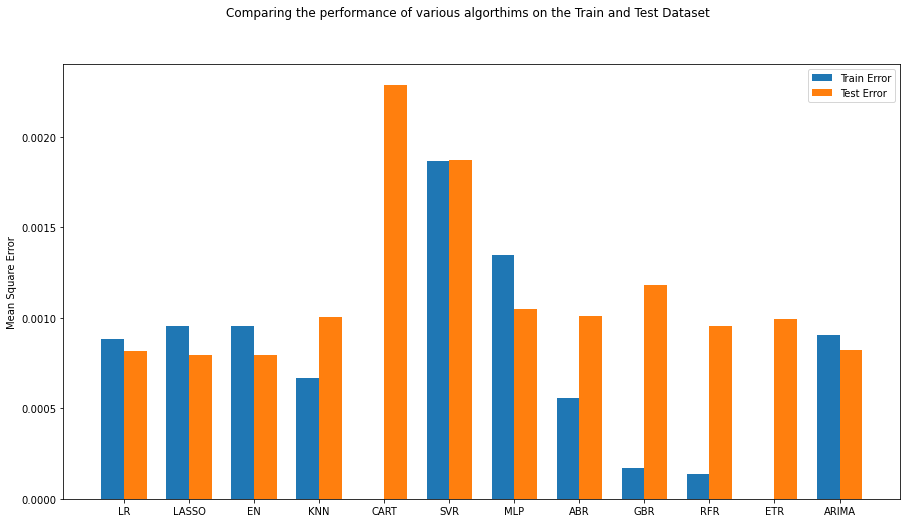

In [141]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

Looking at the chart above, we find time series based ARIMA model comparable to the linear supervised-regression models such as Linear Regression (LR), Lasso Regression (LASSO) and Elastic Net (EN). This can primarily be due to the strong linear relationship as discussed before. Hence, we select the ARIMA model for the model tuning.

<a id='5'></a>
# 6. Model Tuning and Grid Search

As shown in the chart above the ARIMA model is one of the best mode, so we perform the model tuning of the ARIMA model. The default order of ARIMA model is [1,0,0]. We perform a grid search with different combination p,d and q in the ARIMA model's order.  

In [148]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [0, 1, 2, 3]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

ARIMA(0, 0, 0) MSE=0.0009101
ARIMA(0, 0, 1) MSE=0.0009031
ARIMA(0, 0, 2) MSE=0.0009028
ARIMA(0, 1, 0) MSE=0.0017907
ARIMA(0, 1, 1) MSE=0.0009268
ARIMA(0, 1, 2) MSE=0.0009532
ARIMA(0, 2, 0) MSE=0.0050124
ARIMA(0, 2, 1) MSE=0.0018132
ARIMA(0, 2, 2) MSE=0.0009656
ARIMA(1, 0, 0) MSE=0.0009036
ARIMA(1, 0, 1) MSE=0.0009029
ARIMA(1, 0, 2) MSE=0.0009025
ARIMA(1, 1, 0) MSE=0.0014024
ARIMA(1, 1, 1) MSE=0.0009403
ARIMA(1, 1, 2) MSE=0.0009250
ARIMA(1, 2, 0) MSE=0.0030796
ARIMA(1, 2, 1) MSE=0.0014455
ARIMA(1, 2, 2) MSE=0.0012734
ARIMA(2, 0, 0) MSE=0.0009029
ARIMA(2, 0, 1) MSE=0.0008982
ARIMA(2, 0, 2) MSE=0.0009013
ARIMA(2, 1, 0) MSE=0.0012364
ARIMA(2, 1, 1) MSE=0.0009445
ARIMA(2, 1, 2) MSE=0.0009217
ARIMA(2, 2, 0) MSE=0.0023913
ARIMA(2, 2, 1) MSE=0.0012620
ARIMA(2, 2, 2) MSE=0.0014108
ARIMA(3, 0, 0) MSE=0.0009025
ARIMA(3, 0, 1) MSE=0.0009026
ARIMA(3, 0, 2) MSE=0.0009018
ARIMA(3, 1, 0) MSE=0.0011202
ARIMA(3, 1, 1) MSE=0.0009546
ARIMA(3, 1, 2) MSE=0.0009202
ARIMA(3, 2, 0) MSE=0.0018957
ARIMA(3, 2, 1)

<a id='6'></a>
# 7. Finalise the Model

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [145]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=(2,0,1))
model_fit_tuned = modelARIMA_tuned.fit()

In [146]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0008247895194233503


After tuning the model and picking the best ARIMA model or the order 2,0 and 1 we select this model and can it can be used for the modeling purpose. 

<a id='6.2'></a>
## 7.2. Save Model for Later Use

In [147]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = './data/finalized_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))

In [ ]:
#Use the following code to produce the comparison of actual vs. predicted
# predicted_tuned.index = Y_test.index
# pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
# pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
# pyplot.rcParams["figure.figsize"] = (8,5)
# pyplot.show()

### Summary

We can conclude that simple models - linear regression, regularized regression (i.e. Lasso and elastic net) - along with the time series model such as ARIMA are promising modelling approaches for asset price prediction problem. These models can
enable financial practitioners to model time dependencies with a very flexible approach. The overall approach presented in this case study may help us encounter overfitting and underfitting which are some of the key challenges in the prediction
problem in finance.

We should also note that we can use better set of indicators, such as P/E ratio, trading volume, technical indicators or news data, which might lead to better results.

Overall, we created a supervised-regression and time series modelling framework which allows us to perform asset class prediction using historical data to generate results and analyze risk and profitability before risking any actual capital.